<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='background:black; color:white;' role="tab" aria-controls="home"><center style='padding-top: 15px'>Installation</center></h3>

In [1]:
# Install Pycocotools
!pip install 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
# Install detectron 2
!python -m pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.7/index.html

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-_p7a5clf
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-_p7a5clf
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=272382 sha256=3c05fcba5340792a3518a34e7e8bcabe9042454550222f5e0dceef0939c90dbc
  Stored in directory: /tmp/pip-ephem-wheel-cache-tdz6yk9x/wheels/e2/6b/1d/344ac773c7495ea0b85eb228bc66daec7400a143a92d36b7b1
Successfully built pycocotools
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.7/index.html
     |████████████████████████████████| 6.1 MB 5.5 MB/s eta 0:00:01
     |████████████████████████████████| 79 kB 4.7 MB/s eta 0:00:011
     |████████████████████████████████| 154 kB 54.4 MB/s eta 0:00:01
     |████████████████████████████████| 403 kB 58.9 MB/s eta 0:00:01
     |████████████████████████████████| 130 kB 60.0 MB/s eta 0:00:01
     |████████████████████████████████| 50 kB 5.0 M

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='background:black; color:white;' role="tab" aria-controls="home"><center style='padding-top: 15px'>Import Libraries</center></h3>

In [2]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import random
pylab.rcParams['figure.figsize'] = (8.0, 10.0)# Import Libraries

# For visualization
import os
import seaborn as sns
from matplotlib import colors
from tensorboard.backend.event_processing import event_accumulator as ea
from PIL import Image

# Scipy for calculating distance
from scipy.spatial import distance

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='background:black; color:white;' role="tab" aria-controls="home"><center style='padding-top: 15px'>Set constant variables</center></h3>

In [3]:
# I am visualizing some images in the 'val/' directory

dataDir='../input/coco-car-damage-detection-dataset/val'
dataType='COCO_val_annos'
mul_dataType='COCO_mul_val_annos'
annFile='{}/{}.json'.format(dataDir,dataType)
mul_annFile='{}/{}.json'.format(dataDir,mul_dataType)
img_dir = "../input/coco-car-damage-detection-dataset/img"

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='background:black; color:white; border:0' role="tab" aria-controls="home"><center style='padding-top: 15px'> Initialize the COCO API</center></h3>

In [4]:
# initialize coco api for instance annotations
coco=COCO(annFile)
mul_coco=COCO(mul_annFile)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='background:black; color:white;' role="tab" aria-controls="home"><center style='padding-top: 15px' > Import Libraries required for training</center></h3>

In [5]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

1.7.0 True


In [6]:
assert torch.__version__.startswith("1.7")

In [7]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
import skimage.io as io

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.engine import DefaultTrainer
from detectron2.utils.visualizer import ColorMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# Set base params
plt.rcParams["figure.figsize"] = [16,9]

In [8]:
# To find out inconsistent CUDA versions, if there is no "failed" word in this output then things are fine.
!python -m detectron2.utils.collect_env

----------------------  ------------------------------------------------------------------------------
sys.platform            linux
Python                  3.7.9 | packaged by conda-forge | (default, Feb 13 2021, 20:03:11) [GCC 9.3.0]
numpy                   1.19.5
detectron2              0.5 @/opt/conda/lib/python3.7/site-packages/detectron2
Compiler                GCC 7.3
CUDA compiler           CUDA 10.2
detectron2 arch flags   3.7, 5.0, 5.2, 6.0, 6.1, 7.0, 7.5
DETECTRON2_ENV_MODULE   <not set>
PyTorch                 1.7.0 @/opt/conda/lib/python3.7/site-packages/torch
PyTorch debug build     True
GPU available           Yes
GPU 0                   Tesla P100-PCIE-16GB (arch=6.0)
CUDA_HOME               /usr/local/cuda
Pillow                  7.2.0
torchvision             0.8.1 @/opt/conda/lib/python3.7/site-packages/torchvision
torchvision arch flags  3.5, 5.0, 6.0, 7.0, 7.5
fvcore                  0.1.5.post20221221
iopath                  0.1.8
cv2                     4.5.1
----

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='background:black; color:white;' role="tab" aria-controls="home"><center style='padding-top: 15px'>  Register Car Damage Dataset </center></h3>

In [9]:

dataset_dir = "../input/coco-car-damage-detection-dataset"
img_dir = "img/"
train_dir = "train/"
val_dir = "val/"

In [10]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("car_dataset_val", {}, os.path.join(dataset_dir,val_dir,"COCO_val_annos.json"), os.path.join(dataset_dir,img_dir))
register_coco_instances("car_mul_dataset_val", {}, os.path.join(dataset_dir,val_dir,"COCO_mul_val_annos.json"), os.path.join(dataset_dir,img_dir))

<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:black; color:white; ' role="tab" aria-controls="home"><center style='padding-top: 15px'> Load trained model </center></h2>

#### I will load two pretained models:

* Damage Segmentation model weights -  This can be easily created using this notebook [
Detectron2 Car Damage Detection](https://www.kaggle.com/lplenka/detectron2-car-damage-detection). The model is stored in default output directory.

* Parts Segmentation Model weights - This can be also created just changing the dataset from damage annotions to parts annotation in [cell 22](https://www.kaggle.com/lplenka/detectron2-car-damage-detection?scriptVersionId=52171508&cellId=37)



<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:black; color:white; ' role="tab" aria-controls="home"><center style='padding-top: 15px'> Damage Detection Model </center></h2>

In [11]:
#get configuration
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # only has one class (damage) + 1
cfg.MODEL.RETINANET.NUM_CLASSES = 2 # only has one class (damage) + 1
cfg.MODEL.WEIGHTS = os.path.join("../input/coco-damage-detection-trained-models/damage_segmentation_model.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7 
cfg['MODEL']['DEVICE']='cuda'#or cpu
damage_predictor = DefaultPredictor(cfg)


<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:black; color:white; ' role="tab" aria-controls="home"><center style='padding-top: 15px'> Parts Segmentation Model </center></h2>

In [12]:
cfg_mul = get_cfg()
cfg_mul.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg_mul.MODEL.ROI_HEADS.NUM_CLASSES = 6  # only has five classes (headlamp,hood,rear_bumper,front_bumper_door) + 1
cfg_mul.MODEL.RETINANET.NUM_CLASSES = 6 # only has five classes (headlamp,hood,rear_bumper,front_bumper_door) + 1
cfg_mul.MODEL.WEIGHTS = os.path.join("../input/coco-damage-detection-trained-models/part_segmentation_model.pth")
cfg_mul.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7 
cfg_mul['MODEL']['DEVICE']='cuda' #or cpu
part_predictor = DefaultPredictor(cfg_mul)

<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:black; color:white;' role="tab" aria-controls="home"><center style='padding-top: 15px'> Model Inference </center></h2>

In [13]:
def detect_damage_part(damage_dict, parts_dict):
  """
  Returns the most plausible damaged part for the list of damages by checking the distance 
  between centers centers of damage_polygons and parts_polygons

  Parameters
  -------------
   damage_dict: dict
                Dictionary that maps damages to damage polygon centers.
   parts_dict: dict
                Dictionary that maps part labels to parts polygon centers.
  Return
  ----------
  part_name: str
            The most plausible damaged part name.
  """
  try:
    max_distance = 10e9
    assert len(damage_dict)>0, "AssertError: damage_dict should have atleast one damage"
    assert len(parts_dict)>0, "AssertError: parts_dict should have atleast one part"
    max_distance_dict = dict(zip(damage_dict.keys(),[max_distance]*len(damage_dict)))
    part_name = dict(zip(damage_dict.keys(),['']*len(damage_dict)))

    for y in parts_dict.keys():
        for x in damage_dict.keys():
          dis = distance.euclidean(damage_dict[x], parts_dict[y])
          if dis < max_distance_dict[x]:
            part_name[x] = y.rsplit('_',1)[0]

    return list(set(part_name.values()))
  except Exception as e:
    print(e)

In [14]:

damage_class_map= {0:'damage'}
parts_class_map={0:'headlamp',1:'rear_bumper', 2:'door', 3:'hood', 4: 'front_bumper'}

/opt/conda/lib/python3.7/site-packages/detectron2/modeling/roi_heads/fast_rcnn.py:154: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729138878/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  filter_inds = filter_mask.nonzero()


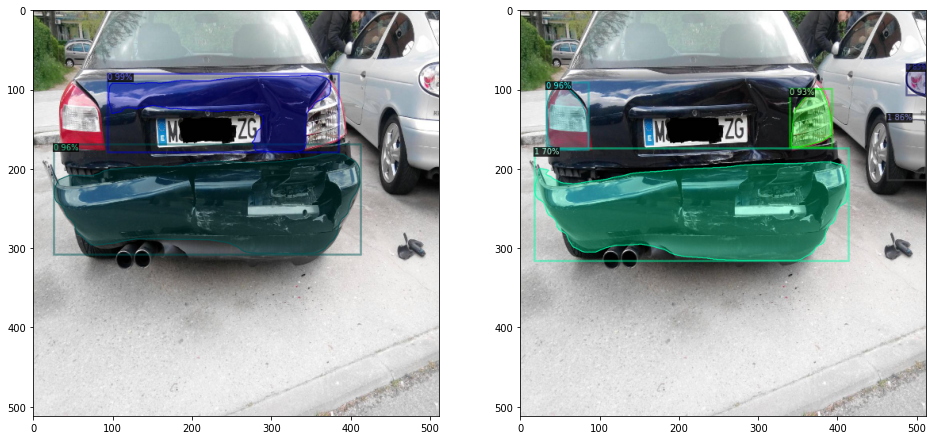

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(16,12))
im = io.imread("../input/coco-car-damage-detection-dataset/val/32.jpg")

#damage inference
damage_outputs = damage_predictor(im)
damage_v = Visualizer(im[:, :, ::-1],
                   metadata=MetadataCatalog.get("car_dataset_val"), 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
)
damage_out = damage_v.draw_instance_predictions(damage_outputs["instances"].to("cpu"))

#part inference
parts_outputs = part_predictor(im)
parts_v = Visualizer(im[:, :, ::-1],
                   metadata=MetadataCatalog.get("car_mul_dataset_val"), 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
)
parts_out = parts_v.draw_instance_predictions(parts_outputs["instances"].to("cpu"))

#plot
ax1.imshow(damage_out.get_image()[:, :, ::-1],)
ax2.imshow(parts_out.get_image()[:, :, ::-1])

Processing: ../input/coco-car-damage-detection-dataset/val/8.jpg


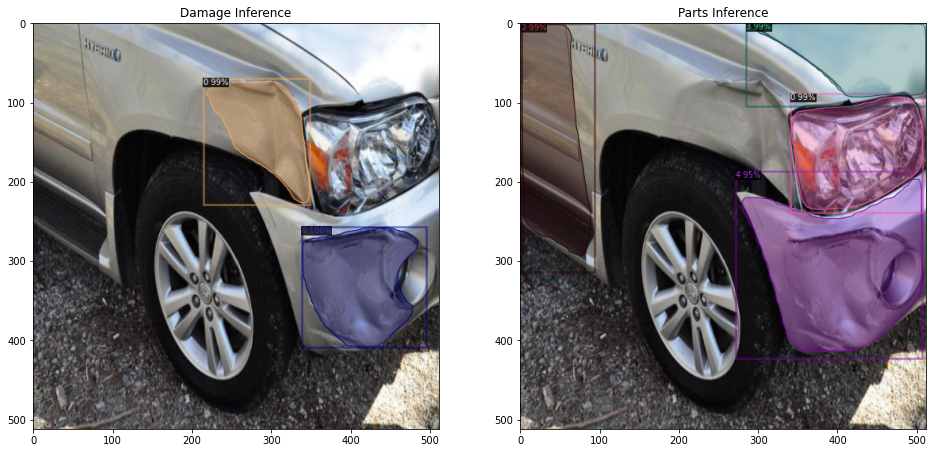

FileNotFoundError: [Errno 2] No such file or directory: 'output/8.jpg'

<Figure size 1152x648 with 0 Axes>

In [16]:
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer, ColorMode
from skimage import io
from detectron2.data import MetadataCatalog
import os

# Directory containing your validation images
image_dir = "../input/coco-car-damage-detection-dataset/val"
image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith('.jpg')]

# Iterate over the images and perform inference
for img_path in image_paths:
    print(f"Processing: {img_path}")  # Log the image being processed

    im = io.imread(img_path)

    # Damage inference
    damage_outputs = damage_predictor(im)
    damage_v = Visualizer(im[:, :, ::-1],
                           metadata=MetadataCatalog.get("car_dataset_val"),
                           scale=0.5,
                           instance_mode=ColorMode.IMAGE_BW)
    damage_out = damage_v.draw_instance_predictions(damage_outputs["instances"].to("cpu"))

    # Part inference
    parts_outputs = part_predictor(im)
    parts_v = Visualizer(im[:, :, ::-1],
                         metadata=MetadataCatalog.get("car_mul_dataset_val"),
                         scale=0.5,
                         instance_mode=ColorMode.IMAGE_BW)
    parts_out = parts_v.draw_instance_predictions(parts_outputs["instances"].to("cpu"))

    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 12))
    ax1.imshow(damage_out.get_image()[:, :, ::-1])
    ax1.set_title("Damage Inference")
    ax2.imshow(parts_out.get_image()[:, :, ::-1])
    ax2.set_title("Parts Inference")
    plt.show()

    # Save or stop after processing
    save_path = os.path.join("output", os.path.basename(img_path))
    plt.savefig(save_path)
    print(f"Saved output to: {save_path}")


In [ ]:
import os
import random
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer, ColorMode
from skimage import io
from detectron2.data import MetadataCatalog

# Directory containing your validation images
image_dir = "../input/coco-car-damage-detection-dataset/val"
image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith('.jpg')]

# Randomly select images to test
num_images_to_test = 5  # Number of random images to test
random_images = random.sample(image_paths, num_images_to_test)

# Output directory for results
output_dir = "output"
os.makedirs(output_dir, exist_ok=True)  # Create the output directory if it doesn't exist

# Iterate over the random images and perform inference
for img_path in random_images:
    print(f"Processing: {img_path}")  # Log the image being processed

    im = io.imread(img_path)

    # Damage inference
    damage_outputs = damage_predictor(im)
    damage_v = Visualizer(im[:, :, ::-1],
                           metadata=MetadataCatalog.get("car_dataset_val"),
                           scale=0.5,
                           instance_mode=ColorMode.IMAGE_BW)
    damage_out = damage_v.draw_instance_predictions(damage_outputs["instances"].to("cpu"))

    # Part inference
    parts_outputs = part_predictor(im)
    parts_v = Visualizer(im[:, :, ::-1],
                         metadata=MetadataCatalog.get("car_mul_dataset_val"),
                         scale=0.5,
                         instance_mode=ColorMode.IMAGE_BW)
    parts_out = parts_v.draw_instance_predictions(parts_outputs["instances"].to("cpu"))

    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 12))
    ax1.imshow(damage_out.get_image()[:, :, ::-1])
    ax1.set_title("Damage Inference")
    ax2.imshow(parts_out.get_image()[:, :, ::-1])
    ax2.set_title("Parts Inference")

    # Save the plot to the output directory
    save_path = os.path.join(output_dir, os.path.basename(img_path))
    plt.savefig(save_path)
    print(f"Saved output to: {save_path}")
    plt.close(fig)  # Close the figure to free memory


<a ><img src="https://i.ibb.co/dP12V6R/damages.jpg" alt="damages" border="0"></a>
<a ><img src="https://i.ibb.co/0QhJGSd/parts.jpg" alt="parts" border="0"></a>

<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:black; color:white;' role="tab" aria-controls="home"><center style='padding-top: 15px'> Create damage polygons </center></h2>

For now allowing multiple polygons of same class label

In [ ]:
damage_prediction_classes = [ damage_class_map[el] + "_" + str(indx) for indx,el in enumerate(damage_outputs["instances"].pred_classes.tolist())]
damage_polygon_centers = damage_outputs["instances"].pred_boxes.get_centers().tolist()
damage_dict = dict(zip(damage_prediction_classes,damage_polygon_centers))

<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:black; color:white;' role="tab" aria-controls="home"><center style='padding-top: 15px'> Create parts polygons </center></h2>

For now allowing multiple polygons of same class label

In [ ]:

parts_prediction_classes = [ parts_class_map[el] + "_" + str(indx) for indx,el in enumerate(parts_outputs["instances"].pred_classes.tolist())]
parts_polygon_centers =  parts_outputs["instances"].pred_boxes.get_centers().tolist()



#Remove centers which lie in beyond 800 units
parts_polygon_centers_filtered = list(filter(lambda x: x[0] < 800 and x[1] < 800, parts_polygon_centers))
parts_dict = dict(zip(parts_prediction_classes,parts_polygon_centers_filtered))

<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:black; color:white;' role="tab" aria-controls="home"><center style='padding-top: 15px'> Damaged Parts </center></h2>

In [ ]:
print("Damaged Parts: ",detect_damage_part(damage_dict,parts_dict))

<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:black; color:white;' role="tab" aria-controls="home"><center style='padding-top: 15px'> Some insights from the performance of model </center></h2>

* Model confuses between front and rear bumper.
* Center of polygon was mostly different from center of bbox.

<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:black; color:white;' role="tab" aria-controls="home"><center style='padding-top: 15px'> Conclusion </center></h2>


* There is definitely a lot of scope for improvement. But this notebook can be a good begining for other complex approaches.
* Data augmentation and training on larger data can significantly improve the results.

### Do give this notebook an upvote if you liked my work, thanks!